In [1]:
# AutoEncoder
# https://medium.com/analytics-vidhya/image-anomaly-detection-using-autoencoders-ae937c7fd2d1

# ogólne
import tensorflow as tf
import numpy as np

# ładowanie danych
from keras.preprocessing.image import ImageDataGenerator

# budowanie modelu
from keras.layers import LeakyReLU, Conv2D, BatchNormalization, Conv2DTranspose, Rescaling
from keras.optimizers import Adam
from keras import Model, Input

# proces uczenia
from keras.callbacks import ModelCheckpoint, EarlyStopping
from datetime import datetime

# wizualizacja
import matplotlib.pyplot as plt
from keras.utils import load_img
import pickle

# klasyfikacja
from keras.models import load_model

# https://stackoverflow.com/questions/58352326/running-the-tensorflow-2-0-code-gives-valueerror-tf-function-decorated-functio
tf.config.run_functions_eagerly(True)  
tf.data.experimental.enable_debug_mode()

In [78]:
# Przygotowanie danych
# https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator

path = r"C:\Users\User\Desktop\Matematyka stosowana - II stopień\III semestr\Uczenie ze wzmocnieniem i deeplearning\deep_learning\Zadanie 1"
nbatch = 64

datagen = ImageDataGenerator(validation_split=0.15,
                             rescale=1./255,
                             rotation_range=10.,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                            #  data_format='channels_last',
                             horizontal_flip=True)

train_data = datagen.flow_from_directory(directory=path+r"\train",
                                         target_size=(224,224),
                                         shuffle=True,
                                         color_mode="grayscale",
                                         batch_size=nbatch,
                                         class_mode="input",
                                        #  classes=None,
                                         subset='training') # set as training data

valid_data = datagen.flow_from_directory(directory=path+r"\train",
                                         target_size=(224,224),
                                         shuffle=True,
                                         color_mode="grayscale",
                                         batch_size=nbatch,
                                         class_mode="input",
                                        #  classes=None,
                                         subset='validation') # set as validation data

Found 890 images belonging to 1 classes.
Found 157 images belonging to 1 classes.


In [136]:
# Create the Encoder and Decoder
inputs = Input(shape=(224, 224, 1), name='input_layer')

#ENCODER
# Conv Block 1 -> BatchNorm->leaky Relu
encoded = Conv2D(32, kernel_size=(3,3), strides= 1, padding='same', name='conv_1')(inputs)
encoded = BatchNormalization(name='batchnorm_1')(encoded)
encoded = LeakyReLU(name='leaky_relu_1')(encoded)
# Conv Block 2 -> BatchNorm->leaky Relu
encoded = Conv2D(64, kernel_size=(3,3), strides= 2, padding='same', name='conv_2')(encoded)
encoded = BatchNormalization(name='batchnorm_2')(encoded)
encoded = LeakyReLU(name='leaky_relu_2')(encoded)
# Conv Block 3 -> BatchNorm->leaky Relu
encoded = Conv2D(64, kernel_size=(3,3), strides=2, padding='same', name='conv_3')(encoded)
encoded = BatchNormalization(name='batchnorm_3')(encoded)
encoded = LeakyReLU(name='leaky_relu_3')(encoded)

# DECODER
# DeConv Block 1-> BatchNorm->leaky Relu
decoded = Conv2DTranspose(64, kernel_size=(3,3), strides= 2, padding='same',name='conv_transpose_1')(encoded)
decoded = BatchNormalization(name='batchnorm_4')(decoded)
decoded = LeakyReLU(name='leaky_relu_4')(decoded)
# DeConv Block 2-> BatchNorm->leaky Relu
decoded = Conv2DTranspose(64, kernel_size=(3,3), strides= 2, padding='same', name='conv_transpose_2')(decoded)
decoded = BatchNormalization(name='batchnorm_5')(decoded)
decoded = LeakyReLU(name='leaky_relu_5')(decoded)
# DeConv Block 3-> BatchNorm->leaky Relu
decoded = Conv2DTranspose(32, kernel_size=(3,3), strides= 1, padding='same', name='conv_transpose_3')(decoded)
decoded = BatchNormalization(name='batchnorm_6')(decoded)
decoded = LeakyReLU(name='leaky_relu_6')(decoded)


#OUTPUT
outputs = Conv2DTranspose(1, kernel_size=(3,3), strides= 1, padding='same', activation='sigmoid', name='conv_transpose_4')(decoded)

In [137]:
def SSIMLoss(y_true, y_pred):
  return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0))

autoencoder = tf.keras.Model(inputs, outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005)
autoencoder.compile(optimizer=optimizer, loss=SSIMLoss)
autoencoder.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 1)]     0         
                                                                 
 conv_1 (Conv2D)             (None, 224, 224, 32)      320       
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 224, 224, 32)     128       
 tion)                                                           
                                                                 
 leaky_relu_1 (LeakyReLU)    (None, 224, 224, 32)      0         
                                                                 
 conv_transpose_3 (Conv2DTra  (None, 224, 224, 32)     9248      
 nspose)                                                         
                                                                 
 batchnorm_6 (BatchNormaliza  (None, 224, 224, 32)     128

In [138]:
metric = "val_loss"

# String formatting rules - https://mkaz.blog/code/python-string-format-cookbook/
filepath=path+"\\AutoEncoder\\models\\weights-improvement-epoch{epoch:03d}-loss{val_loss:.3f}.hdf5"

# steps = https://stackoverflow.com/questions/60509425/how-to-use-repeat-function-when-building-data-in-keras
steps = train_data.samples//nbatch
epoch = 10
valid_steps = valid_data.samples//nbatch

checkpoint = ModelCheckpoint(filepath,
                             monitor=metric,
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto',
                             save_freq="epoch")

early = EarlyStopping(monitor=metric,
                      min_delta=0,
                      patience=epoch//2,
                      verbose=1,
                      mode='auto')

hist = autoencoder.fit(x=train_data,
                       batch_size=nbatch,
                       epochs=epoch,
                       steps_per_epoch=steps,
                       validation_data=valid_data,
                       validation_steps=valid_steps,
                       shuffle=True,
                       callbacks=[checkpoint,early])

Epoch 1/10
13/13 [==============================] - ETA: 0s - loss: 0.1852 
Epoch 1: val_loss improved from inf to 0.37072, saving model to C:\Users\User\Desktop\Matematyka stosowana - II stopień\III semestr\Uczenie ze wzmocnieniem i deeplearning\deep_learning\Zadanie 1\AutoEncoder\models\weights-improvement-epoch001-loss0.371.hdf5
13/13 [==============================] - 168s 13s/step - loss: 0.1852 - val_loss: 0.3707
Epoch 2/10
13/13 [==============================] - ETA: 0s - loss: 0.0632 
Epoch 2: val_loss did not improve from 0.37072
13/13 [==============================] - 172s 13s/step - loss: 0.0632 - val_loss: 0.3754
Epoch 3/10
13/13 [==============================] - ETA: 0s - loss: 0.0380 
Epoch 3: val_loss improved from 0.37072 to 0.36801, saving model to C:\Users\User\Desktop\Matematyka stosowana - II stopień\III semestr\Uczenie ze wzmocnieniem i deeplearning\deep_learning\Zadanie 1\AutoEncoder\models\weights-improvement-epoch003-loss0.368.hdf5
13/13 [====================

In [139]:
# zapisanie historii nauki
name = "epochs_{}_steps_{}_{:%Y_%m_%d_%H_%M}".format(checkpoint.params['epochs'], checkpoint.params['steps'], datetime.now())
with open('trainHistoryDict/{}.pickle'.format(name), 'wb') as file_pi:
    pickle.dump(hist.history, file_pi)

# otwarcie historii nauki
with open('trainHistoryDict/{}.pickle'.format(name), "rb") as file_pi:
    history = pickle.load(file_pi)

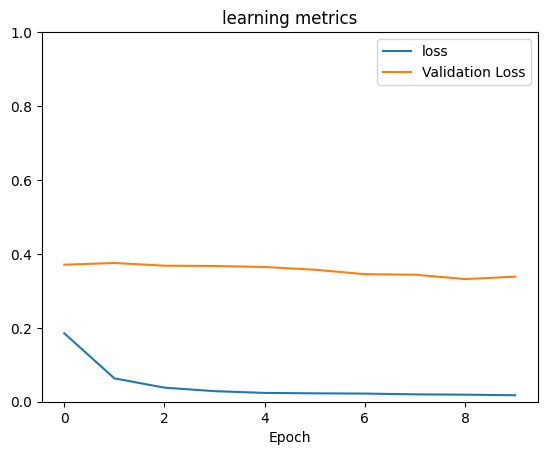

In [140]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.ylim(0, 1) 
plt.title("learning metrics")
plt.xlabel("Epoch")
plt.legend(["loss","Validation Loss"])
plt.show()

In [141]:
# https://stackoverflow.com/questions/52270177/how-to-use-predict-generator-on-new-images-keras
# https://vijayabhaskar96.medium.com/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720
datagen_test = ImageDataGenerator(rescale=1./255)

test_data = datagen_test.flow_from_directory(directory=path+r"\test",
                                             target_size=(224,224),
                                             shuffle=False,
                                             color_mode="grayscale",
                                             class_mode="input",)

test_data.reset() # else weird outputs will come.

# problem customowej funkcji straty - https://github.com/keras-team/keras/issues/5916
model = load_model("models/weights-improvement-epoch009-loss0.332.hdf5", custom_objects={'SSIMLoss': SSIMLoss})

decoded_imgs = model.predict(test_data)

# pred=model.predict_generator(test_data, verbose=1)
# predicted_class_indices=pred.round().flatten()

# labels = (train_data.class_indices)
# labels = dict((v,k) for k,v in labels.items())
# predictions = [labels[k] for k in predicted_class_indices]

Found 25 images belonging to 1 classes.
1/1 [==============================] - 1s 1s/step


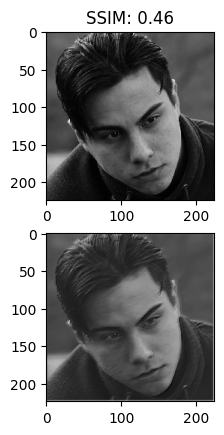

In [142]:
# SINGLE IMAGE PREDICTION
# Image number
img_n = 0

ssi = SSIMLoss(test_data[0][0][img_n],decoded_imgs[img_n]).numpy()
# tf.print("SSIMLoss:",ssi)

ax = plt.subplot(2,1,1)
plt.imshow(test_data[0][0][img_n], cmap='gray')
plt.title("SSIM: {:.2f}".format(ssi))

ax = plt.subplot(2,1,2)
plt.imshow(decoded_imgs[img_n], cmap='gray')

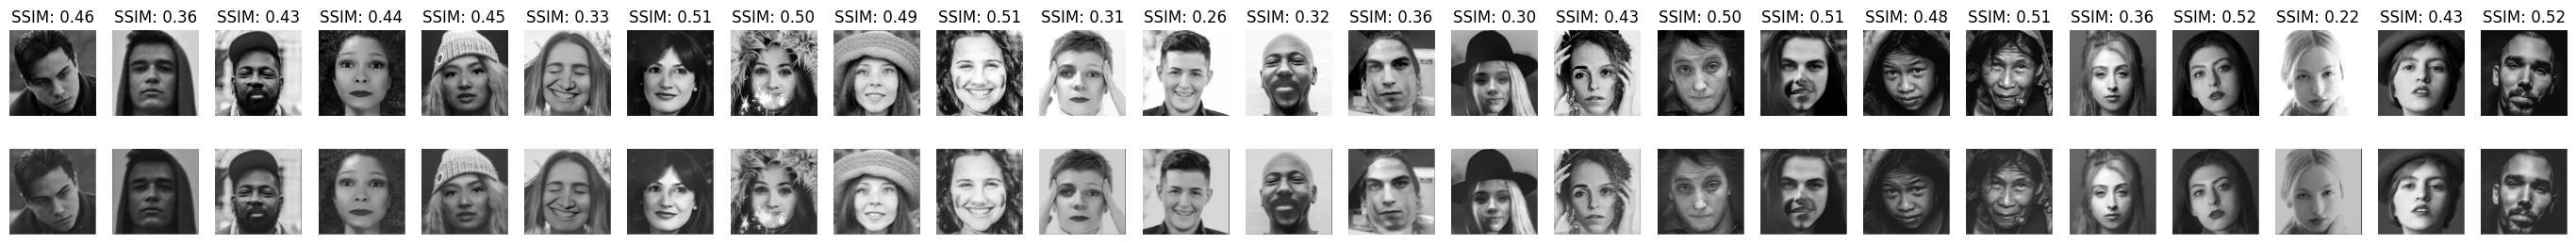

In [143]:
# Wykorzystac zbior z falszywkami zeby sredni prog bledu

# WHOLE TEST SET PREDICTION 
n = test_data.samples
plt.figure(figsize=(35,3))

for i in range(1, n+1):

    ssi = SSIMLoss(test_data[0][0][i-1],decoded_imgs[i-1]).numpy()
    if ssi >= 0.4:
        call = "REAL"
    else:
        call = "FAKE"

    ax = plt.subplot(2,n,i)
    plt.axis('off')
    plt.imshow(test_data[0][0][i-1], cmap='gray')
    plt.title("SSIM: {:.2f}".format(ssi))

    ax = plt.subplot(2,n,i+n)
    plt.axis('off')
    plt.imshow(decoded_imgs[i-1], cmap='gray')